In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
from src.folder_handler import *
from src.cort_processor import *
from src.tdt_support import *
from src.plotter import *
from src.decoders import *
import pickle
import scipy as spicy
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
from src.wiener_filter import *
from matplotlib.pyplot import cm
from scipy import signal


In [2]:
with open('/mnt/c/oobootoo/rat-fes/data/pickles/rat-annie_5-12_session.pkl', 'rb') as inp:
    session512 = pickle.load(inp)
rates = session512.data['rates']
angles = session512.data['angles']
coords = session512.data['coords']

In [3]:
ts = np.linspace(0, (angles[0].shape[0]*50)/1000,angles[0].shape[0])

In [4]:
def sin_and_cos(angles):
    cos_list = []
    sin_list = []
    phase_list = []
    # holding_array = []
    for i in range(len(angles)):
        cos_array = []
        sin_array = []
        raw_phase_angle = []
        for ii in range(angles[i].shape[1]):
            # holding_array = np.zeros(angles[i].shape)
            peak_list = []
            peak_dict = {
                    0 : {
                        'signal': -(angles[i][:,ii]),
                        'prominence': 5,
                        'distance': 5,
                        'width' : 2,
                        'height' : -1.25*np.mean(angles[i][:,ii])
                    },
                    1 : {
                        'signal': angles[i][:,ii],
                        'prominence': 10,
                        'distance': None,
                        'width' : None,
                        'height' : np.mean(angles[i][:,ii])
                    },
                    2 : {
                        'signal': angles[i][:,ii],
                        'prominence': 5,
                        'distance': None,
                        'width' : 2,
                        'height' : np.mean(angles[i][:,ii])
                    },
                    3 : {
                        'signal': angles[i][:,ii],
                        'prominence': 10,
                        'distance': None,
                        'width' : None,
                        'height' : np.mean(angles[i][:,ii])
                    },
                    4 : {
                        'signal': angles[i][:,ii],
                        'prominence': 6.5,
                        'distance': 5,
                        'width' : None,
                        'height' : 1.1*np.mean(angles[i][:,ii])
                    },
                    5 : {
                        'signal': -(angles[i][:,ii]),
                        'prominence': 5,
                        'distance': None,
                        'width' : None,
                        'height' : -1.1*np.mean(angles[i][:,ii])
                    },
                    6 : {
                        'signal': angles[i][:,ii],
                        'prominence': 9,
                        'distance': 5,
                        'width' : None,
                        'height' : None
                    }
                }
            peak_list, _ = spicy.signal.find_peaks(peak_dict[ii]['signal'], prominence=peak_dict[ii]['prominence'], distance =peak_dict[ii]['distance'], width =peak_dict[ii]['width'], height =peak_dict[ii]['height'])
            angle_storage = angles[i][:,ii].copy()
            for iii in range(0,peak_list.shape[0]-1):
                for iv in range(0, peak_list[iii+1]-peak_list[iii]):
                    angle_storage[peak_list[iii]+iv] = iv*360/(peak_list[iii+1]-peak_list[iii])
            angle_storage[peak_list[-1]] = 0
            angle_sin = (np.sin(angle_storage*np.pi/180))
            sin_array.append(angle_sin)
            angle_cos = (np.cos(angle_storage*np.pi/180))
            cos_array.append(angle_cos)
            raw_phase_angle.append(angle_storage)
        sin_array = np.array(sin_array).T
        sin_list.append(sin_array)
        cos_array = np.array(cos_array).T
        cos_list.append(cos_array)
        raw_phase_angle = np.array(raw_phase_angle).T
        phase_list.append(raw_phase_angle)
    # h, _, _, _ = session512.decode_angles(X=rates, Y=angles)
    # h_sin, _, _, _ = session512.decode_angles(X=rates, Y=sin_list)
    # h_cos, _, _, _ = session512.decode_angles(X=rates, Y=cos_list)
    # full_rates, full_angles = session512.stitch_and_format(rates, angles)
    # _, full_sin = session512.stitch_and_format(rates, sin_list)
    # _, full_cos = session512.stitch_and_format(rates, cos_list)\
    return sin_list, cos_list, phase_list

In [5]:
sin_waves, cos_waves, phase_list = sin_and_cos(angles)

h, vaff, x_test, y_test = session512.decode_angles(X=rates, Y=angles)
full_rates, full_angles = session512.stitch_and_format(rates, angles)
h_sin, _, _, _ = session512.decode_angles(X=rates, Y=sin_waves)
_, full_sin= session512.stitch_and_format(rates, sin_waves)
h_cos, _, _, _ = session512.decode_angles(X=rates, Y=cos_waves)
_, full_cos = session512.stitch_and_format(rates, cos_waves)
_, full_phase = session512.stitch_and_format(rates, phase_list)
full_angles.shape

(14210, 7)

In [6]:
def predicted_lines(actual, H):
    holding_array = []
    for ii in range(0,7):
        temp1 = test_wiener_filter(actual, H[:,ii])
        holding_array.append(temp1)
    holding_array = np.array(holding_array).T
    return holding_array

In [7]:
predicted_angle = predicted_lines(full_rates, h)
predicted_sin = predicted_lines(full_rates, h_sin)
predicted_cos = predicted_lines(full_rates, h_cos)
tsf = np.linspace(0, (full_angles.shape[0]*50)/1000,full_angles.shape[0])


In [25]:
arctans = []
for i in range(predicted_sin.shape[1]):
    arctan_angles = (np.arctan2(predicted_sin[:,i],predicted_cos[:,i]) * 180 / np.pi) +180
    arctans.append(arctan_angles)
arctans = np.array(arctans).T
arctans.shape

1
2
3
4
5
6
7


(14210, 7)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
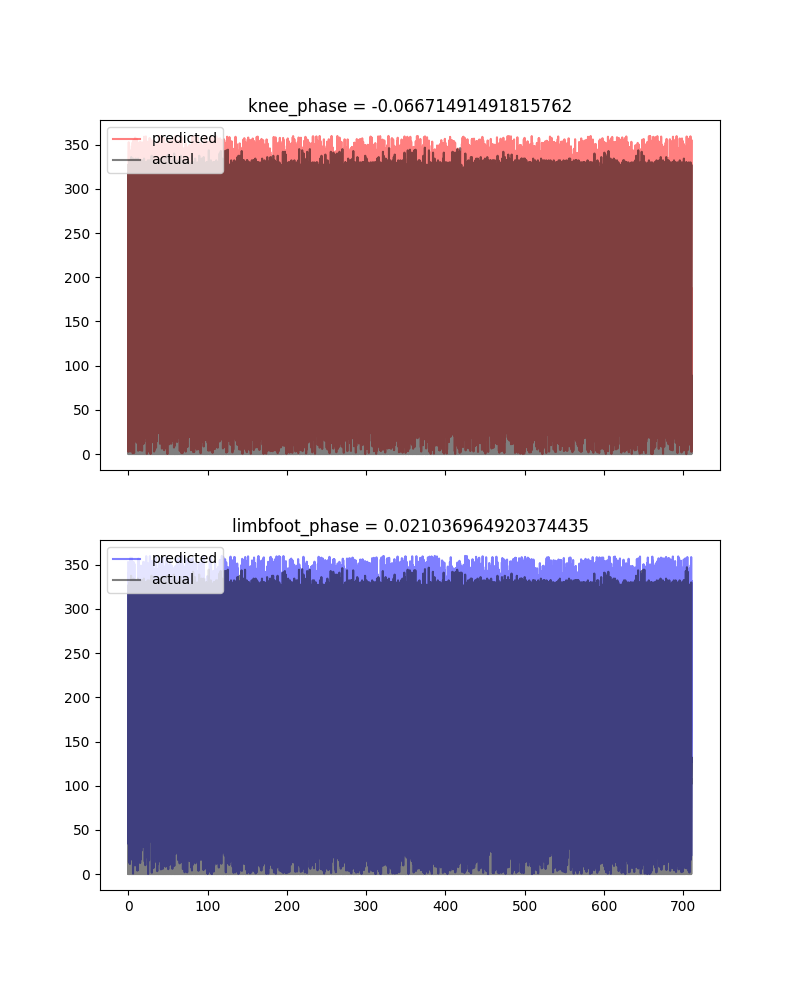

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(8,10), sharex = True)
ax[0].set_title('knee_phase = ' + str(vaf(full_phase[:,1],np.roll(arctans[:,1], -7))))
ax[0].plot(tsf, np.roll(arctans[:,1], -7), c='r', alpha=0.5, label = "predicted")
ax[0].plot(tsf, full_phase[:,1], c='k', alpha=0.5, label = "actual")
ax[0].legend(loc="upper left")
ax[1].set_title('limbfoot_phase = ' + str(vaf(full_phase[:,3],np.roll(arctans[:,3], -7))))
ax[1].plot(tsf, np.roll(arctans[:,3], -7), c='blue', alpha=0.5, label = "predicted")
ax[1].plot(tsf, full_phase[:,3], c='k', alpha=0.5, label = "actual")
ax[1].legend(loc="upper left")

In [10]:
dx = np.mean(np.diff(tsf))
temp_shift = []
target = [arctans[:,0], arctans[:,1], arctans[:,2], arctans[:,3], arctans[:,4], arctans[:,5], arctans[:,6]]
for i in range(len(target)):
    shift = (np.argmax(signal.correlate(full_phase[:,i], target[i])) - len(target[i])) * dx
    temp_shift.append(shift)
print(temp_shift)
print(full_phase.shape)

[-0.35002463227531844, -0.35002463227531844, -0.35002463227531844, -0.35002463227531844, -0.35002463227531844, -0.35002463227531844, -0.35002463227531844]
(14210, 7)


In [11]:
shift1 = (np.argmax(signal.correlate(full_phase[:,3], target[3])) - len(target[3])) * dx
print(shift1)

-0.35002463227531844


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
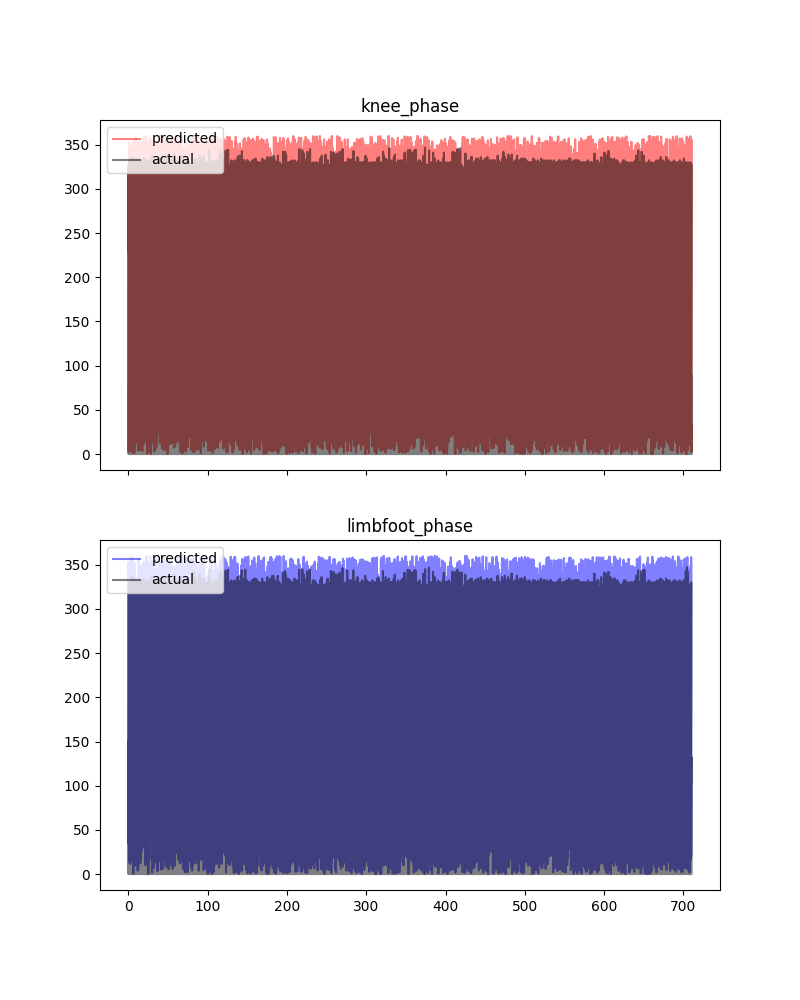

In [28]:
fig00, ax = plt.subplots(2, 1, figsize=(8,10), sharex = True)
ax[0].set_title('knee_phase')# = ' + str(vaf(full_phase[:,1],arctans[:,1])))
ax[0].plot(tsf+temp_shift[1], arctans[:,1], c='r', alpha=0.5, label = "predicted")
ax[0].plot(tsf, full_phase[:,1], c='k', alpha=0.5, label = "actual")
ax[0].legend(loc="upper left")


ax[1].set_title('limbfoot_phase')# = ' + str(vaf(full_phase[:,3],arctans[:,3])))
ax[1].plot(tsf+temp_shift[3], arctans[:,3], c='blue', alpha=0.5, label = "predicted")
ax[1].plot(tsf, full_phase[:,3], c='k', alpha=0.5, label = "actual")
ax[1].legend(loc="upper left")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
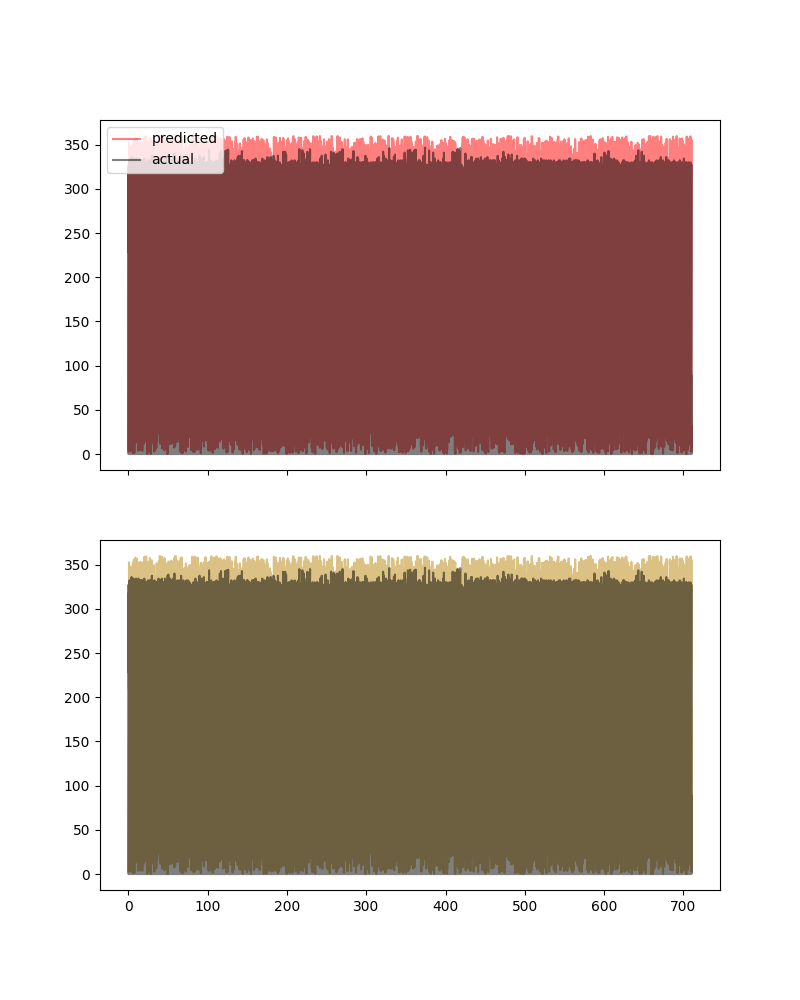

In [13]:
fig00, ax = plt.subplots(2, 1, figsize=(8,10), sharex = True)
ax[0].plot(tsf+temp_shift[1], arctans[:,1], c='r', alpha=0.5, label = "predicted")
ax[0].plot(tsf, full_phase[:,1], c='k', alpha=0.5, label = "actual")
ax[0].legend(loc="upper left")

ax[1].plot(tsf, np.roll(arctans[:,1], -7), c='darkgoldenrod', alpha=0.5, label = "rolled")
ax[1].plot(tsf, full_phase[:,1], c='k', alpha=0.5, label = "actual")



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
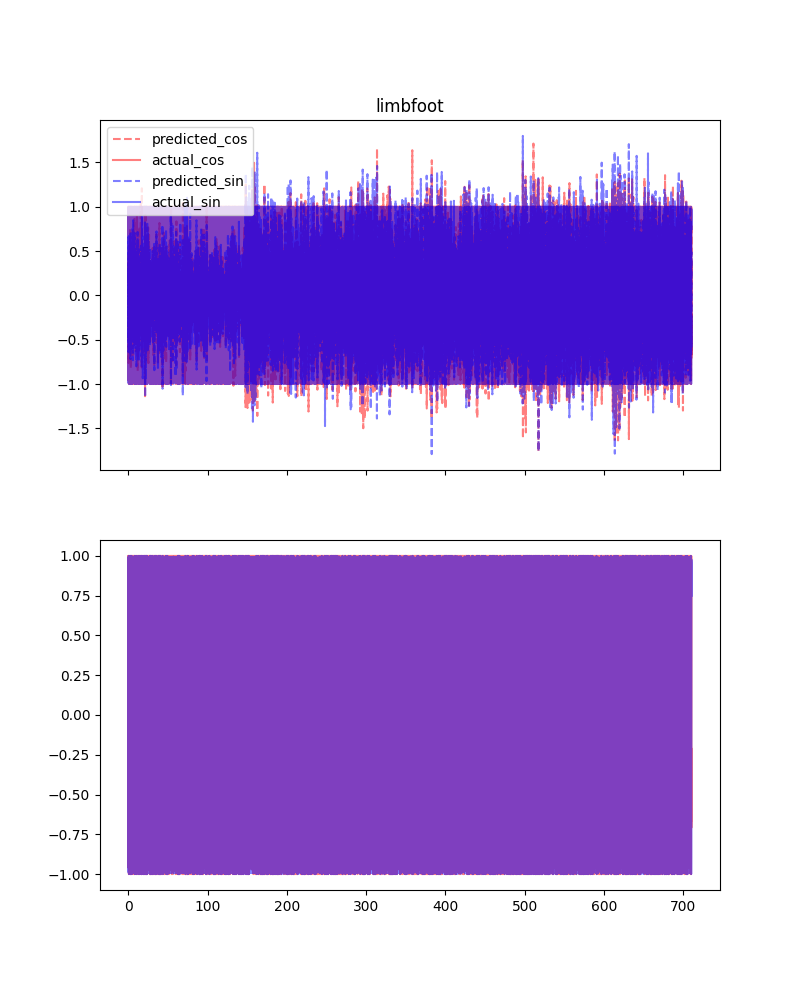

In [22]:
fig00, ax = plt.subplots(2, 1, figsize=(8,10), sharex = True)
ax[0].set_title('limbfoot') 

ax[0].plot(tsf, predicted_cos[:,3], c='r', alpha=0.5, label = "predicted_cos", linestyle = '--')
ax[0].plot(tsf, full_cos[:,3], c='r', alpha=0.5, label = "actual_cos")
ax[0].legend(loc="upper left")

# ax[1].set_title('limbfoot sin') 
ax[0].plot(tsf, predicted_sin[:,3], c='blue', alpha=0.5, label = "predicted_sin", linestyle = '--')
ax[0].plot(tsf, full_sin[:,3], c='b', alpha=0.5, label = "actual_sin")
ax[0].legend(loc="upper left")

ax[1].plot(tsf, full_cos[:,3], c='r', alpha=0.5)
ax[1].plot(tsf, np.roll(full_sin[:,3],0), c='b', alpha=0.5,)


In [23]:
def cosine_align(waves):#, plot_req):
    shift_list = []
    for i in range(len(waves)):
        ts = np.linspace(0, (waves[i].shape[0]*50)/1000,waves[i].shape[0])
        dx = np.mean(np.diff(ts))
        temp_shift = []
        for target in [waves[i][:,0], cos_waves[i][:,1], cos_waves[i][:,2]]:
            shift = (np.argmax(signal.correlate(cos_waves[i][:,3], target)) - len(target)) * dx
            temp_shift.append(shift)
        temp_shift.append(0)
        for target in [waves[i][:,4], cos_waves[i][:,5]]:
            shift = (np.argmax(signal.correlate(cos_waves[i][:,6], target)) - len(target)) * dx
            temp_shift.append(shift)
        temp_shift.append(0)
        temp_shift = np.array(temp_shift).T
        shift_list.append(temp_shift)  
    return shift_list
    # if plot_req == 1:

shifts = cosine_align(cos_waves)
print(shifts)

# fig, axs = plt.subplots(2, 1, figsize=(8,10), sharex=True)
# axs[0].set_title('hindlimb')
# axs[0].plot(ts, cos_waves[0][:,0], c='red', label = "ankle", alpha = 0.5)
# axs[0].plot(ts, cos_waves[0][:,1], c='blue', label = "knee", alpha = 0.5)
# axs[0].plot(ts, cos_waves[0][:,2], c='yellow', label = "hip", alpha = 0.5)
# axs[0].plot(ts, cos_waves[0][:,3], c='green', label = "limbfoot", alpha = 0.5)
# axs[0].legend(loc="upper left")

# axs[1].set_title('forelimb')
# axs[1].plot(ts, cos_waves[0][:,4], c='red', label = "elbow", alpha = 0.5)
# axs[1].plot(ts, cos_waves[0][:,5], c='blue', label = "shoulder", alpha = 0.5)
# axs[1].plot(ts, cos_waves[0][:,6], c='green', label = "forelimb", alpha = 0.5)
# axs[1].legend(loc="upper left")

[array([-0.45015198, -0.25008443,  0.        ,  0.        , -0.05001689,
       -0.10003377,  0.        ]), array([ 0.10003447, -0.25008618, -0.05001724,  0.        , -0.05001724,
       -0.10003447,  0.        ]), array([ 0.10002486, -0.25006216, -0.05001243,  0.        , -0.05001243,
       -0.10002486,  0.        ]), array([ 0.10002293, -0.25005731, -0.05001146,  0.        , -0.05001146,
       -0.10002293,  0.        ])]


In [ ]:
# fig, axs = plt.subplots(2, 1, figsize=(8,10), sharex= True)
# axs[0].set_title('hindlimb')
# axs[0].plot(ts, angles[0][:,0], c='red', label = "ankle")
# axs[0].plot(ts, angles[0][:,1], c='black', label = "knee")
# axs[0].plot(ts, angles[0][:,2], c='blue', label = "hip")
# axs[0].plot(ts, angles[0][:,3], c='black', label = "limbfoot", linestyle = ":")
# axs[0].legend(loc="upper left")



# axs[1].set_title('forelimb')
# axs[1].plot(ts, angles[0][:,4], c='red', label = "elbow")
# axs[1].plot(ts, angles[0][:,5], c='black', label = "shoulder")
# axs[1].plot(ts, angles[0][:,6], c='blue', label = "forelimb")
# axs[1].legend(loc="upper left")
